In [5]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/26/5a/27fd341e4510257789f19a4b4be8bb90d1113b8f176c3dab562b4f21466e/matplotlib-3.8.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/ca/2a/d197a412ec474391ee878b1218cf2fe9c6e963903755887fc5654c06636a/contourpy-1.2.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/c4/d8/a68085e2da45aad6acebf512fe2d9fe783d6af3efad4a3b0d708783f891b/fonttools-4.46.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/159.4 kB ? eta -:--:--
     ---------------------- ---------------- 92.2/159.4 kB 2.6 MB/s e


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\Joshua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import DBcm
import random
import matplotlib.pyplot as plt
import numpy as np


In [3]:
"""Run below to creat some game data, graphs at bottom"""

'Run below to creat some game data, graphs at bottom'

In [4]:
creds = {
    'host': 'localhost',
    'database': 'BlackJackDB',
    'user': 'josh',
    'password': 'password'
}


In [5]:
def random_gamer():    
    with DBcm.UseDatabase(creds) as db:
        SQL = """
        select gamertag from players
        """
        db.execute(SQL)
        tags = db.fetchall()
        tags = [row[0] for row in tags] 
        who = random.choice(tags)
    return who

In [6]:
def update_games_database(gamertag, outcome, isTwentyOne):
    """ updates the game data"""
    SQL = """
        insert into games
        (gamertag, outcome,21s)
        values
        (%s,%s,%s)      
        """


    with DBcm.UseDatabase(creds) as db:
        db.execute(SQL, (gamertag, outcome, isTwentyOne))

        SQL = """select * from games"""
        db.execute(SQL)
        results = db.fetchall()

In [7]:
def generate_game_data():
    """ populates database"""
    for _ in range(100):
        gamer = random_gamer()
        outcome = random.choice(["Win", "Loss"])

        if(outcome == "Win"):
        
            twentyOne = random.choice(["yes", "no", "no"]) # just to make it less likely they wil get 21
        else:
            twentyOne = "no"
        
      
        update_games_database(gamer, outcome, twentyOne)


In [19]:
def get_player_names():
    """gets a list of players names"""
    with DBcm.UseDatabase(creds) as db:
        SQL = """
        select gamertag from players
        """
        db.execute(SQL)
        tags = db.fetchall()
        tags = [row[0] for row in tags] 
    return tags

In [9]:
def get_21s(player):
    """gets a player number of 21s from table"""
    with DBcm.UseDatabase(creds) as db: 
        SQL = """select 21s from games where gamertag = %s """
        db.execute(SQL,(player,))
        results = db.fetchall()
        twentyOnesResults = 0
        for result in results:
            if "yes" in result:
                twentyOnesResults+=1
    return twentyOnesResults

In [10]:
def get_highest_win_streak(player):
    """gets a players highest win streak"""
    with DBcm.UseDatabase(creds) as db: 

        SQL = """select HighestWinStreak from gamestats where gamertag = %s"""
        db.execute(SQL,(player, ))
        currentHighScore = db.fetchone()
        

        SQL = """select outcome from games where gamertag = %s """
        db.execute(SQL,(player,))
        results = db.fetchall()
        
        highestWinStreak = 0; 
        winStreak =0; 
        
        for result in results:
            if "Loss" in result:
                if(highestWinStreak < winStreak):
                     highestWinStreak = winStreak
                winStreak = 0
            else:
                winStreak +=1
            
        if( winStreak != 0):
            if( winStreak > highestWinStreak):
                highestWinStreak = winStreak


    return highestWinStreak

In [11]:
def get_winrate(player):
    "gets a players win rate"
    with DBcm.UseDatabase(creds) as db: 
        SQL = """
        select count(*) from games 
        where gamertag = %s and outcome = "Win"
        """
        db.execute(SQL,(player,))
        results = db.fetchone()
        wins = results[0]

        SQL = """
        select count(*) from games 
        where gamertag = %s and outcome = "Loss"
        """
        db.execute(SQL,(player,))
        results = db.fetchone()
        losses = results[0]

        winRate = (wins/(wins + losses)) * 100

        return winRate

In [12]:
def update_gameStats(winrate, high_streak, twenty_ones, gamertag):
    """updates the stats table if there is a gamer tag exist and inserts if none """
    with DBcm.UseDatabase(creds) as db: 
            ## check if user exist first 
            SQL = """select gamertag from gamestats where gamertag = %s """
            db.execute(SQL,(gamertag,))
            result = db.fetchone()
            if result is None:
                SQL = """ 
                    insert into gamestats
                    (gamertag, winrate, HighestWinStreak, 21s)
                    values
                    (%s,%s, %s, %s)      
                    """
                db.execute(SQL,(gamertag,winrate,high_streak,twenty_ones))
            else:
                SQL = """
                update gamestats 
                set winrate = %s, HighestWinStreak = %s, 21s =%s 
                where gamertag =%s
                """
                db.execute(SQL,(winrate,high_streak,twenty_ones, gamertag))
                  

In [35]:
generate_game_data()
players = get_player_names()
for player in players:

    update_gameStats(get_winrate(player), get_highest_win_streak(player), get_21s(player), player)

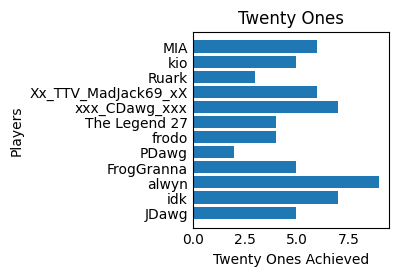

In [30]:
players = get_player_names()
twentyOnes =[]
for player in players:
    twentyOnes.append(get_21s(player))

x = players

y = twentyOnes
fig, ax = plt.subplots()


plt.barh(x,y)
plt.xlabel("Twenty Ones Achieved" )
plt.ylabel("Players")
plt.title("Twenty Ones")
plt.show()



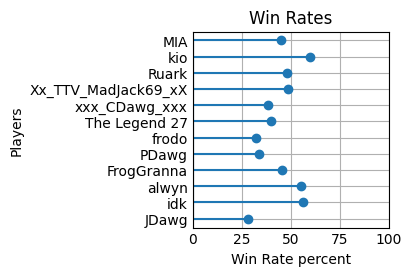

In [43]:


players = get_player_names()
winRate =[]
for player in players:
    winRate.append(get_winrate(player))

plt.style.use('_mpl-gallery')

# make data
x = 1 + np.arange(12)
y = winRate

# plot
fig, ax = plt.subplots()

ax.stem(players, winRate, orientation = "horizontal")
ax.set(xlim=(0, 100))
plt.title("Win Rates")
plt.xlabel("Win Rate percent" )
plt.ylabel("Players")

plt.show()

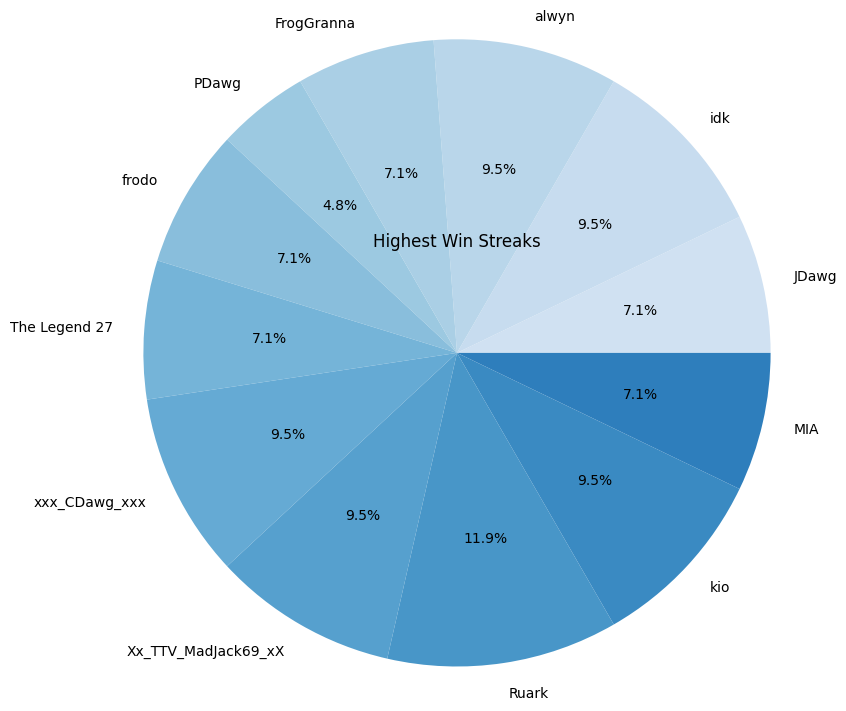

In [28]:
players = get_player_names()
winStreaks =[]
for player in players:
    winStreaks.append(get_highest_win_streak(player))


plt.style.use('_mpl-gallery-nogrid')


# make data
x = winStreaks
colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, len(x)))

# plot
fig, ax = plt.subplots()
ax.pie(x, labels= players,colors=colors, radius= 4, autopct="%1.1f%%")
plt.title("Highest Win Streaks")


plt.show()